# Import

In [1]:
import pandas as pd
import numpy as np
import time
import os
from os import listdir
import sys
import io
from PIL import Image
from functools import reduce

#Chargez PySpark à l'aide du package findSpark
#import findspark
#findspark.init()
import pyspark

# Context & Session
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession, Row

# Bibliothèques objets Python pour Apache Arrow
import pyarrow

# Connextion à S3 AWS
import boto3

# Traitement des données
from pyspark.sql.functions import element_at
from pyspark.sql.functions import col, pandas_udf, PandasUDFType
from pyspark.sql.functions import udf, split, lit
from pyspark.sql.types import ArrayType, StringType, IntegerType, DoubleType, DataType, FloatTyp
from pyspark.sql.types import *
from typing import Iterator

# Taches machine learning
from pyspark.ml.image import ImageSchema
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, StandardScaler
from pyspark.ml.feature import PCA

#  Modules matplotlib
import matplotlib.pyplot as plt

In [2]:
print(os.environ['PATH'])

/usr/local/cuda-10.0/bin:/opt/amazon/openmpi/bin:/opt/amazon/efa/bin:/home/ec2-user/anaconda3/condabin:/home/ec2-user/.dl_binaries/bin:/usr/local/cuda/bin:/usr/libexec/gcc/x86_64-amazon-linux/4.8.5:/home/ec2-user/anaconda3/envs/python3/bin:/home/ec2-user/anaconda3/condabin:/opt/amazon/openmpi/bin:/opt/amazon/efa/bin:/home/ec2-user/anaconda3/condabin:/home/ec2-user/.dl_binaries/bin:/usr/local/cuda/bin:/usr/libexec/gcc/x86_64-amazon-linux/4.8.5:/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/sbin:/opt/aws/bin:/opt/aws/bin


# Versions

In [3]:
! pyspark --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 2.4.0
      /_/
                        
Using Scala version 2.11.12, OpenJDK 64-Bit Server VM, 1.8.0_302
Branch 
Compiled by user  on 2018-10-29T06:22:05Z
Revision 
Url 
Type --help for more information.


In [4]:
! python --version

Python 3.6.13


In [5]:
! java -version

java version "1.7.0_261"
OpenJDK Runtime Environment (amzn-2.6.22.1.83.amzn1-x86_64 u261-b02)
OpenJDK 64-Bit Server VM (build 24.261-b02, mixed mode)


# Fonctions

In [6]:
def recuperer_chemin(images_path):
            images_path = images_path.replace("s3://monprojet8/", "")
        
            s3 = boto3.resource("s3")
            
            bucket = s3.Bucket("monprojet8")
            object = bucket.Object(images_path)
            response = object.get()
            file = response['Body']
            return file

In [7]:
def redimensionner_image(images_path, size=(20,20)):

        image = Image.open(images_path)
        image = image.resize((20, 20))

        return image

In [8]:
def type_fruit(chemin):
    
    liste = chemin.split("/")
    categ = liste[-2]
    
    return categ    

# Lancement d'une session Spark

In [9]:
import sagemaker
from sagemaker import get_execution_role
import sagemaker_pyspark

role = get_execution_role()

# Configure Spark to use the SageMaker Spark dependency jars
jars = sagemaker_pyspark.classpath_jars()

classpath = ":".join(sagemaker_pyspark.classpath_jars())

# Lancement d'une session Spark
spark = ( 
    SparkSession.builder.config("spark.driver.extraClassPath", classpath)
    .master('local[*]')
    .appName('DS_P8')
    .getOrCreate()
            )

In [10]:
region = boto3.Session().region_name
endpoint_domain = "com"

hadoopConf = spark._jsc.hadoopConfiguration() 
hadoopConf.set("fs.s3a.endpoint", "s3.{}.amazonaws.{}".format(region, endpoint_domain))
#hadoopConf.set("fs.s3a.endpoint", "s3.eu-west-3.amazonaws.com")
hadoopConf.set("com.amazonaws.services.s3a.enableV4", "true")
hadoopConf.set("fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")

In [11]:
spark

# Base de données

## Chargement des images stockées sur S3

In [12]:
# URL des images
url_data = 's3a://monprojet8/P8_02_data_images/*'

In [13]:
# Charger des données dans un spark_df
fruit_picture = spark.read.format('image').load(url_data) 

In [14]:
# printSchema() Renvoie le schéma de l'image.
# Imprime le schéma sous forme d'arborescence.
fruit_picture.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



In [15]:
# printSchema() Renvoie le schéma de l'image.
# toNDArray( image ) Convertit une image en un tableau avec des métadonnées.
# Utiliser un transformateur intégré du type binaire au tableau, en passant en mode RVB
ImageArray_first = ImageSchema.toNDArray(fruit_picture.first()['image'])[:, :, ::-1]

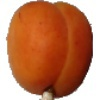

In [16]:
# PIL.Image. fromarray ( obj , mode = Aucun )
# Crée une mémoire d'image à partir d'un objet exportant l'interface de tableau (en utilisant le protocole buffer).
Image.fromarray(ImageArray_first)

##  Création d'un spark dataframe

In [17]:
session = boto3.session.Session()
s3_client = session.client(service_name='s3', region_name="eu-west-1")
s3 = boto3.client('s3')

In [18]:
# Création une liste contenant tous les chemins des images stockées dans S3
paginator = s3.get_paginator('list_objects_v2')
page_iterator = paginator.paginate(Bucket='monprojet8', Prefix='P8_02_data_images/')
prefixe = 'P8_02_data_images/'
list_path =  []
sub_folders = s3_client.list_objects_v2(Bucket="monprojet8", Prefix=prefixe)
for page in page_iterator :
    for obj in page['Contents']:
        list_path.append("s3://monprojet8"+"/"+obj['Key'])

In [19]:
# Création d'un RDD à partir de la liste des chemins d'accès aux images
rdd = spark.sparkContext.parallelize(list_path)
row_rdd = rdd.map(lambda x: Row(x))
# Création d'un dataFrame pyspark à partir d'un RDD
fruit_picture_df = spark.createDataFrame(row_rdd, ["path"])

In [20]:
fruit_picture_df.show(6,truncate = 58)

+-------------------------------------------------+
|                                             path|
+-------------------------------------------------+
|    s3://projet8ocr/data_images/Apricot/0_100.jpg|
|  s3://projet8ocr/data_images/Apricot/r_0_100.jpg|
|    s3://projet8ocr/data_images/Avocado/0_100.jpg|
|s3://projet8ocr/data_images/Avocado/r_100_100.jpg|
|     s3://projet8ocr/data_images/Banana/0_100.jpg|
|    s3://projet8ocr/data_images/Banana/73_100.jpg|
+-------------------------------------------------+



# Prepocessing

## Ajout de la colonne donnant le type de fruit (label) 

In [21]:
udf_label = udf(type_fruit, StringType())
fruit_picture_df = fruit_picture_df.withColumn("fruit_name", udf_label('path'))        

In [22]:
fruit_picture_df.show(6,truncate = 58)

+-------------------------------------------------+----------+
|                                             path|fruit_name|
+-------------------------------------------------+----------+
|    s3://projet8ocr/data_images/Apricot/0_100.jpg|   Apricot|
|  s3://projet8ocr/data_images/Apricot/r_0_100.jpg|   Apricot|
|    s3://projet8ocr/data_images/Avocado/0_100.jpg|   Avocado|
|s3://projet8ocr/data_images/Avocado/r_100_100.jpg|   Avocado|
|     s3://projet8ocr/data_images/Banana/0_100.jpg|    Banana|
|    s3://projet8ocr/data_images/Banana/73_100.jpg|    Banana|
+-------------------------------------------------+----------+



## Redimensionnement des l'images

In [23]:
ud_f = udf(lambda x: np.asarray(redimensionner_image(recuperer_chemin(x))).flatten().tolist())
fruit_picture_df = fruit_picture_df.withColumn('image', ud_f('path'))

In [24]:
fruit_picture_df.show(6,truncate = 58)

+-------------------------------------------------+----------+----------------------------------------------------------+
|                                             path|fruit_name|                                                     image|
+-------------------------------------------------+----------+----------------------------------------------------------+
|    s3://projet8ocr/data_images/Apricot/0_100.jpg|   Apricot|[253, 254, 253, 253, 255, 252, 254, 255, 253, 255, 255,...|
|  s3://projet8ocr/data_images/Apricot/r_0_100.jpg|   Apricot|[255, 255, 255, 255, 255, 255, 255, 255, 255, 252, 254,...|
|    s3://projet8ocr/data_images/Avocado/0_100.jpg|   Avocado|[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,...|
|s3://projet8ocr/data_images/Avocado/r_100_100.jpg|   Avocado|[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,...|
|     s3://projet8ocr/data_images/Banana/0_100.jpg|    Banana|[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,...|
|    s3://projet8ocr/dat

## StandardScaler

Avant de pouvoir réduire la dimensionnalité de l'ensemble de données à l'aide de l'ACP, nous devons d'abord normaliser les features.

StandardScaler peut prendre deux paramètres :
 - withMean : False par défaut. Centre les données avec la moyenne avant mise à l'échelle.
 - withStd : True par défaut. Met à l'échelle les données à l'écart type de l'unité.

In [25]:
# conversion format vecteur dense
ud_f = udf(lambda r: Vectors.dense(r), VectorUDT())
fruit_picture_df = fruit_picture_df.withColumn('image', ud_f('image'))

In [26]:
#standardisation des données
standardizer = StandardScaler(inputCol="image", outputCol="std_features",
                              withStd=True, withMean=True)
model_std = standardizer.fit(fruit_picture_df)
fruit_picture_df = model_std.transform(fruit_picture_df)

In [27]:
fruit_picture_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- fruit_name: string (nullable = true)
 |-- image: vector (nullable = true)
 |-- std_features: vector (nullable = true)



# PCA

In [28]:
# Réduction de dimension
pca = PCA(k=4, inputCol='std_features', outputCol='pca_features')
model_pca = pca.fit(fruit_picture_df)

In [29]:
# Transformation des images sur les k premières composantes
fruit_picture_df = model_pca.transform(fruit_picture_df)

In [30]:
fruit_picture_df = fruit_picture_df.filter(fruit_picture_df.pca_features.isNotNull())

In [31]:
fruit_picture_df.show()

+--------------------+----------+--------------------+--------------------+--------------------+
|                path|fruit_name|               image|        std_features|        pca_features|
+--------------------+----------+--------------------+--------------------+--------------------+
|s3://projet8ocr/d...|   Apricot|[253.0,254.0,253....|[-2.0412414523193...|[13.7049849872450...|
|s3://projet8ocr/d...|   Apricot|[255.0,255.0,255....|[0.40824829046384...|[13.8919405452722...|
|s3://projet8ocr/d...|   Avocado|[255.0,255.0,255....|[0.40824829046384...|[16.7925927320891...|
|s3://projet8ocr/d...|   Avocado|[255.0,255.0,255....|[0.40824829046384...|[10.4838127380582...|
|s3://projet8ocr/d...|    Banana|[255.0,255.0,255....|[0.40824829046384...|[-31.432505182032...|
|s3://projet8ocr/d...|    Banana|[255.0,255.0,255....|[0.40824829046384...|[-23.440825820632...|
+--------------------+----------+--------------------+--------------------+--------------------+



Text(0, 0.5, 'Variance cumulée')

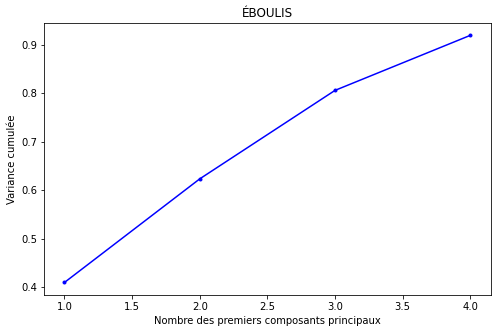

In [32]:
eVc = model_pca.explainedVariance.cumsum()
#plt.rcParams['figure.facecolor']='w'
plt.figure(figsize=(8,5))
plt.plot(range(1,len(eVc)+1), eVc, color='b',
         marker = '.', linestyle='-')
plt.title('ÉBOULIS')
plt.xlabel('Nombre des premiers composants principaux')
plt.ylabel('Variance cumulée')

# Sauvegarde dans S3

In [33]:
# Sauvegarde au format parquet
fruit_picture_df.write.format('parquet').mode('overwrite').save('s3a://monprojet8/resultats_parquet')

In [34]:
# Sauvegarde au format csv
fruit_picture_panda_df = fruit_picture_df.toPandas()
s3 = boto3.client("s3", region_name='eu-west-1')
fruit_picture_panda_df.to_csv('s3://projet8ocr/resultats/resultats.csv', index=False)